In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, chain
import tqdm
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.autograd import Variable



from nosaveddata.nsd_utils.networks import params_count, params_and_grad_norm, seed_np_torch
from nosaveddata.nsd_utils.einstein import Rearrange
from nosaveddata.builders.weight_init import *

from nosaveddata.builders.mlp import *
from nosaveddata.builders.resnet import IMPALA_Resnet, DQN_Conv
from nosaveddata.builders.token_learner import TokenLearner
from nosaveddata.builders.moe import SoftMoE_Combine_Output


from utils.experience_replay import *


import locale
locale.getpreferredencoding = lambda: "UTF-8"

import wandb


# Environment configuration
env_name = 'Assault'
SEED = 7783


wandb.init(
    project="Atari-100k-MoE",
    name=f"BBF MoE {env_name}",

    #id='rotdmtc5',
    #resume='must',

    config={
        "learning_rate": 1e-4,
        "architecture": "BBF",
        "dataset": "Assault",
        "epochs": 100,
    },

    reinit=False
)




# Optimization
batch_size = 32
lr=1e-4

eps=1e-8


# Target network EMA rate
critic_ema_decay=0.995
#critic_ema_decay=0.98


# Return function
initial_gamma=torch.tensor(1-0.97).log()
final_gamma=torch.tensor(1-0.997).log()

initial_n = 10
final_n = 3

num_buckets=51


# Reset Schedule and Buffer
reset_every=40000 # grad steps, not steps.
replay_ratio=2
schedule_max_step=reset_every//4
total_steps=100000

prefetch_cap=1 # actually, no prefetch is being done


Transition = namedtuple('Transition',
                        ('state', 'reward', 'action', 'c_flag'))
memory = PrioritizedReplay_nSteps_Sqrt(100005, total_steps=schedule_max_step, prefetch_cap=prefetch_cap)



def save_checkpoint(net, model_target, optimizer, step, path):
    torch.save({
            'model_state_dict': net.state_dict(),
            'model_target_state_dict': model_target.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'step': step,
            }, path)


C:\Users\sneep\anaconda3\envs\python_\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sneep\anaconda3\envs\python_\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
wandb: Currently logged in as: snykralafk. Use `wandb login --relogin` to force relogin


In [2]:
# https://github.com/weipu-zhang/STORM/blob/main/env_wrapper.py
class MaxLast2FrameSkipWrapper(gym.Wrapper):
    def __init__(self, env, skip=4, seed=0):
        super().__init__(env)
        self.seed = seed
        self.skip = skip
        self.env.action_space.seed(seed)
        
    def reset(self, **kwargs):
        kwargs["seed"] = self.seed
        obs, _ = self.env.reset(**kwargs)
        return obs, _

    def step(self, action):
        total_reward = 0
        self.obs_buffer = deque(maxlen=2)
        for _ in range(self.skip):
            obs, reward, done, truncated, info = self.env.step(action)
            self.obs_buffer.append(obs)
            total_reward += reward

            terminated = np.logical_or(done, truncated)
            #if terminated.any():
            #    for i in range(len(terminated)):
            #       obs[i] = self.reset()[0][i]
            if done or truncated:
                break
        if len(self.obs_buffer) == 1:
            obs = self.obs_buffer[0]
        else:
            obs = np.max(np.stack(self.obs_buffer), axis=0)
        return obs, total_reward, done, truncated, info
        # Life loss is calculated on the training code

env = gym.vector.make(f"{env_name}NoFrameskip-v4", num_envs=1)
env = MaxLast2FrameSkipWrapper(env,seed=SEED)


#n_actions = env.action_space.n
n_actions = env.action_space[0].n

state, info = env.reset()
n_observations = len(state)

seed_np_torch(SEED)

C:\Users\sneep\anaconda3\envs\python_\Lib\site-packages\gymnasium\vector\__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(


In [3]:

def renormalize(tensor, has_batch=False):
    shape = tensor.shape
    tensor = tensor.view(tensor.shape[0], -1)
    max_value,_ = torch.max(tensor, -1, keepdim=True)
    min_value,_ = torch.min(tensor, -1, keepdim=True)
    return ((tensor - min_value) / (max_value - min_value + 1e-5)).view(shape)


class DQN(nn.Module):
    def __init__(self, n_actions, hiddens=2048, mlp_layers=1, scale_width=4,
                 n_atoms=51, Vmin=-10, Vmax=10):
        super().__init__()
        self.support = torch.linspace(Vmin, Vmax, n_atoms).cuda()
        
        self.hiddens=hiddens
        self.scale_width=scale_width
        self.act = nn.ReLU()
        
        
        self.encoder_cnn = IMPALA_Resnet(scale_width=scale_width, norm=False, init=init_xavier, act=self.act)
        
        
        
        # Single layer dense that maps the flattened encoded representation into hiddens.
        self.rearrange = Rearrange('b c h w -> b (h w) c')
        self.moe = SoftMoE_Combine_Output(32*scale_width, hiddens, num_experts=4, num_slots=1)
        self.prediction = MLP(hiddens, out_hiddens=hiddens, layers=1, last_init=init_xavier)
                                              
        self.transition = nn.Sequential(DQN_Conv(128+n_actions, 128, 3, 1, 1, norm=False, init=init_xavier, act=self.act),
                                        DQN_Conv(128, 128, 3, 1, 1, norm=False, init=init_xavier, act=self.act))

        # Single layer dense that maps hiddens into the output dim according to:
        # 1. https://arxiv.org/pdf/1707.06887.pdf -- Distributional Reinforcement Learning
        # 2. https://arxiv.org/pdf/1511.06581.pdf -- Dueling DQN
        self.a = MLP(hiddens, out_hiddens=n_actions*num_buckets, layers=1, in_act=self.act, last_init=init_xavier)
        self.v = MLP(hiddens, out_hiddens=num_buckets, layers=1, in_act=self.act, last_init=init_xavier)
    
        params_count(self, 'DQN')
    
    def forward(self, X, y_action):
        X, z, _ = self.encode(X)
        
        
        q, action = self.q_head(X)
        z_pred, combine_w = self.get_transition(z, y_action)

        return q, action, X[:,1:].clone().detach(), z_pred, combine_w
    

    def env_step(self, X):
        with torch.no_grad():
            X, _, _ = self.encode(X)
            _, action = self.q_head(X)
            
            return action.detach()
    

    def encode(self, X):
        batch, seq = X.shape[:2]
        self.batch = batch
        self.seq = seq
        X = self.encoder_cnn(X.contiguous().view(self.batch*self.seq, *(X.shape[2:])))
        X = renormalize(X).contiguous().view(self.batch, self.seq, *X.shape[-3:])
        X = X.contiguous().view(self.batch, self.seq, *X.shape[-3:])
        z = X.clone()
        X, combine_w = self.moe(self.rearrange(X.view(self.batch*self.seq, *X.shape[-3:])))
        X = X.view(self.batch*self.seq, -1)
        return X, z, combine_w

    def get_transition(self, z, action):
        z = z.contiguous().view(-1, *z.shape[-3:])
        
        action = F.one_hot(action.clone(), n_actions).view(-1, n_actions)
        action = action.view(-1, 5, n_actions, 1, 1).expand(-1, 5, n_actions, *z.shape[-2:])

        
        z_pred = torch.cat( (z, action[:,0]), 1)
        z_pred = self.transition(z_pred)
        z_pred = renormalize(z_pred)
        
        z_preds=[z_pred.clone()]
        

        for k in range(4):
            z_pred = torch.cat( (z_pred, action[:,k+1]), 1)
            z_pred = self.transition(z_pred)
            z_pred = renormalize(z_pred)
            
            z_preds.append(z_pred)
        
        
        z_pred = torch.stack(z_preds,1)

        z_pred, combine_w = self.moe(self.rearrange(z_pred.view(-1,*z_pred.shape[-3:])))
        z_pred = self.prediction(z_pred.view(self.batch,5,-1))
        
        return z_pred, combine_w.view(self.batch,5,-1)

    
    def q_head(self, X):
        q = self.dueling_dqn(X)
        action = (q*self.support).sum(-1).argmax(-1)
        
        return q, action

    def get_max_action(self, X):
        with torch.no_grad():
            X, _, _ = self.encode(X)
            q = self.dueling_dqn(X)
            
            action = (q*self.support).sum(-1).argmax(-1)
            return action

    def evaluate(self, X, action):
        with torch.no_grad():
            X, _, _ = self.encode(X)
            
            q = self.dueling_dqn(X)
            
            action = action[:,:,None,None].expand_as(q)[:,:,0][:,:,None]
            q = q.gather(-2,action)
            
            return q

    def dueling_dqn(self, X):
        X = F.relu(X)
        
        a = self.a(X).view(self.batch, -1, n_actions, num_buckets)
        v = self.v(X).view(self.batch, -1, 1, num_buckets)
        
        q = v + a - a.mean(-2,keepdim=True)
        q = F.softmax(q,-1)
        
        return q
    
    def network_ema(self, rand_network, target_network, alpha=0.5):
        for param, param_target in zip(rand_network.parameters(), target_network.parameters()):
            param_target.data = alpha * param_target.data + (1 - alpha) * param.data.clone()

    def hard_reset(self, random_model, alpha=0.5):
        with torch.no_grad():
            
            self.network_ema(random_model.encoder_cnn, self.encoder_cnn, alpha)
            self.network_ema(random_model.transition, self.transition, alpha)

            self.network_ema(random_model.moe, self.moe, 0)
            self.network_ema(random_model.prediction, self.prediction, 0)

            self.network_ema(random_model.a, self.a, 0)
            self.network_ema(random_model.v, self.v, 0)



def copy_states(source, target):
    for key, _ in zip(source.state_dict()['state'].keys(), target.state_dict()['state'].keys()):
        target.state_dict()['state'][key]['exp_avg_sq'] = copy.deepcopy(source.state_dict()['state'][key]['exp_avg_sq'])
        target.state_dict()['state'][key]['exp_avg'] = copy.deepcopy(source.state_dict()['state'][key]['exp_avg'])
        target.state_dict()['state'][key]['step'] = copy.deepcopy(source.state_dict()['state'][key]['step'])
        
def target_model_ema(model, model_target):
    with torch.no_grad():
        for param, param_target in zip(model.parameters(), model_target.parameters()):
            param_target.data = critic_ema_decay * param_target.data + (1.0 - critic_ema_decay) * param.data.clone()


    
model=DQN(n_actions).cuda()
model_target=DQN(n_actions).cuda()

model_target.load_state_dict(model.state_dict())


# Testing only
with torch.no_grad():
    q, action, X, z_pred, combine_w = model(torch.randn(4,1,12,96,72, device='cuda', dtype=torch.float), torch.randint(0,n_actions,(4,5),device='cuda').long())
#z = model.encode(torch.randn(4,5,12,96,72, device='cuda'))[0]

# I believe the authors have actually miscalculated the params count on the paper.
# My training time is lower than theirs while having more parameters, and the same architecture is used as is their original code

IMPALA ResNet Parameters: 1.56M
Soft MoE Parameters: 0.27M
DQN Parameters: 7.16M
IMPALA ResNet Parameters: 1.56M
Soft MoE Parameters: 0.27M
DQN Parameters: 7.16M


In [4]:
perception_modules=[model.encoder_cnn, model.transition]
actor_modules=[model.prediction, model.moe, model.a, model.v]

params_wm=[]
for module in perception_modules:
    for param in module.parameters():
        if param.requires_grad==True:
            params_wm.append(param)

params_ac=[]
for module in actor_modules:
    for param in module.parameters():
        if param.requires_grad==True:
            params_ac.append(param)


optimizer = torch.optim.AdamW(chain(params_wm, params_ac),
                                lr=lr, weight_decay=0.1, eps=1.5e-4)

In [5]:
import torchvision.transforms as transforms

train_tfms = transforms.Compose([
                         transforms.Resize((96,72)),
                        ])


def preprocess(state):
    state=torch.tensor(state, dtype=torch.float, device='cuda') / 255
    state=train_tfms(state.permute(0,3,1,2))
    return state

# https://github.com/google/dopamine/blob/master/dopamine/jax/agents/dqn/dqn_agent.py
def linearly_decaying_epsilon(decay_period, step, warmup_steps, epsilon):
    steps_left = decay_period + warmup_steps - step
    bonus = (1.0 - epsilon) * steps_left / decay_period
    bonus = np.clip(bonus, 0., 1. - epsilon)
    return epsilon + bonus


def epsilon_greedy(Q_action, step, final_eps=0, num_envs=1):
    epsilon = linearly_decaying_epsilon(2001, step, 2000, final_eps)
    
    if random.random() < epsilon:
        action = torch.randint(0, n_actions, (num_envs,), dtype=torch.int64, device='cuda').squeeze(0)
    else:
        action = Q_action.view(num_envs).squeeze(0).to(torch.int64)
    return action


In [6]:
# https://github.com/google/dopamine/blob/master/dopamine/jax/agents/rainbow/rainbow_agent.py
def project_distribution(supports, weights, target_support):
    with torch.no_grad():
        v_min, v_max = target_support[0], target_support[-1]
        # `N` in Eq7.
        num_dims = target_support.shape[-1]
        # delta_z = `\Delta z` in Eq7.
        delta_z = (v_max - v_min) / (num_buckets-1)
        # clipped_support = `[\hat{T}_{z_j}]^{V_max}_{V_min}` in Eq7.
        clipped_support = supports.clip(v_min, v_max)
        # numerator = `|clipped_support - z_i|` in Eq7.
        numerator = (clipped_support[:,None] - target_support[None,:,None].repeat_interleave(clipped_support.shape[0],0)).abs()
        quotient = 1 - (numerator / delta_z)
        # clipped_quotient = `[1 - numerator / (\Delta z)]_0^1` in Eq7.
        clipped_quotient = quotient.clip(0, 1)
        # inner_prod = `\sum_{j=0}^{N-1} clipped_quotient * p_j(x', \pi(x'))` in Eq7.
        inner_prod = (clipped_quotient * weights[:,None]).sum(-1)
        #inner_prod = (clipped_quotient).sum(-1) * weights
        return inner_prod.squeeze()


mse = torch.nn.MSELoss(reduction='none')


scaler = torch.cuda.amp.GradScaler()
def optimize(step, grad_step, n):
        
    model.train()
    model_target.train()

    with torch.autocast(device_type='cuda', dtype=torch.bfloat16, enabled=False):
        with torch.no_grad():
            states, next_states, rewards, action, c_flag, idxs, is_w = memory.sample(n, batch_size, grad_step)
        terminal=1-c_flag
        #print(f"STUFF HERE {states.shape, rewards.shape, c_flag.shape, action.shape, n}")
    
    
        q, max_action, _, z_pred, combine_w_pred = model(states[:,0][:,None], action[:,:5].long())
        with torch.no_grad():
            z, _, combine_w_target = model_target.encode(states[:,1:6])
        

        
        
        max_action  = model.get_max_action(next_states[:,n-1][:,None])
        next_values = model_target.evaluate(next_states[:,n-1][:,None].contiguous(), max_action)
        

        action = action[:,0,None].expand(batch_size,num_buckets)
        action=action[:,None]
        with torch.no_grad():
            gammas_one=torch.ones(batch_size,n,1,dtype=torch.float,device='cuda')
            gamma_step = 1-torch.tensor(( (schedule_max_step - min(grad_step, schedule_max_step)) / schedule_max_step) * (initial_gamma-final_gamma) + final_gamma).exp()
            gammas=gammas_one*gamma_step

            
            returns = []
            for t in range(n):
                ret = 0
                for u in reversed(range(t, n)):
                    ret += torch.prod(c_flag[:,t+1:u+1],-2)*torch.prod(gammas[:,t:u],-2)*rewards[:,u+1]
                returns.append(ret)
            returns = torch.stack(returns,1)
        
        plot_vs = returns.clone().sum(-1)
        
        same_traj = (torch.prod(c_flag[:,:n],-2)).squeeze()
        
        returns = returns[:,0]
        returns = returns + torch.prod(gammas[0,:10],-2).squeeze()*same_traj[:,None]*model.support[None,:]
        returns = returns.squeeze()
        
        next_values = next_values[:,0]

        log_probs = torch.log(q[:,0].gather(-2, action)[:,None] + eps).contiguous()
        
        
        dist = project_distribution(returns, next_values.squeeze(), model.support)

        loss = -(dist*(log_probs.squeeze())).sum(-1).view(batch_size,-1).sum(-1)
        dqn_loss = loss.clone().mean()
        td_error = (loss + torch.nan_to_num((dist*torch.log(dist))).sum(-1)).mean()

        
        batched_loss = loss.clone()
        
        
        z = F.normalize(z, 2, dim=-1, eps=1e-5)
        z_pred = F.normalize(z_pred, 2, dim=-1, eps=1e-5)

        
        recon_loss = (mse(z_pred.contiguous().view(-1,2048), z.contiguous().view(-1,2048))).sum(-1)
        recon_loss = recon_loss.view(batch_size, -1)
        combine_w_target = combine_w_target.view(batch_size, 5, -1)
        rho = ((combine_w_pred.log() - combine_w_target.log()).abs().clip(0,1)).mean(-1)
        recon_loss = recon_loss#*rho
        recon_loss = 5*(recon_loss.view(batch_size, -1).mean(-1))*same_traj

        
        loss += recon_loss
        
        loss = (loss*is_w).mean() # mean across batch axis

    loss.backward()

    param_norm, grad_norm = params_and_grad_norm(model)
    #scaler.scale(loss).backward()
    #scaler.unscale_(optimizer)
    #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
    #scaler.step(optimizer)
    #scaler.update()
    
    optimizer.step()
    optimizer.zero_grad()
    
    #memory.set_priority(idxs, batched_loss)
    memory.set_priority(idxs, batched_loss, same_traj)
    
    
    lr = optimizer.param_groups[0]['lr']
    wandb.log({'loss': loss, 'dqn_loss': dqn_loss, 'recon_loss': recon_loss.mean(), 'lr': lr, 'returns': plot_vs.mean(),
               'is_w': is_w.mean(), 'td_error': td_error, 'param_norm': param_norm.sum(), 'grad_norm': grad_norm.sum(),
               'rho': rho.mean()})




scores=[]
memory.free()
step=0
#model.share_memory()
grad_step=0

In [7]:
step=0

progress_bar = tqdm.tqdm(total=total_steps)

while step<(10):
    state, info = env.reset()
    state = preprocess(state)

    stacked = state.repeat_interleave(3,1)
    state = torch.cat((stacked.clone(), state),1)
    
    
    eps_reward=torch.tensor([0], dtype=torch.float)
    
    reward=np.array([0])
    done_flag=np.array([False])
    terminated=np.array([False])

    last_lives=np.array([0])
    life_loss=np.array([0])
    
    last_grad_update=0
    while step<(total_steps):
        progress_bar.update(1)
        model_target.train()
        
        len_memory = len(memory)
        Q_action = model_target.env_step(state.unsqueeze(0))
        
        action = epsilon_greedy(Q_action, len_memory).cpu()
        
        memory.push(state.detach().cpu(), reward, action, np.logical_or(done_flag, life_loss))
        #print('action', action, action.shape)
        
        state, reward, terminated, truncated, info = env.step([action.numpy()])
        
        state = preprocess(state)
        eps_reward+=reward
        reward = reward.clip(-1, 1)

        state = torch.cat((stacked.clone(), state),1)
        stacked = torch.cat((stacked[:,3:], state[:,-3:]),1)

        
        done_flag = np.logical_or(terminated, truncated)
        lives = info['lives']
        life_loss = (last_lives-lives).clip(min=0)
        last_lives = lives

        
        n = int(initial_n * (final_n/initial_n)**(min(grad_step,schedule_max_step) / schedule_max_step))
        n = np.array(n).item()
        
        memory.priority[len_memory] = memory.max_priority()
        

        if len_memory>2000:
            for i in range(replay_ratio):
                optimize(step, grad_step, n)
                target_model_ema(model, model_target)
                grad_step+=1

        
        if ((step+1)%10000)==0:
            save_checkpoint(model, model_target, optimizer, step,
                            'checkpoints/moe_atari_last.pth')
        
            
        
        if grad_step>reset_every:
            #eval()
            print('Reseting on step', step, grad_step)
            
            seed_np_torch(random.randint(SEED-1000, SEED+1000)+step)
            random_model = DQN(n_actions).cuda()
            model.hard_reset(random_model)
            
            seed_np_torch(random.randint(SEED-1000, SEED+1000)+step)
            random_model = DQN(n_actions).cuda()
            model_target.hard_reset(random_model)
            seed_np_torch(SEED)
            
            random_model=None
            grad_step=0

            actor_modules=[model.prediction, model.moe, model.a, model.v]
            params_ac=[]
            for module in actor_modules:
                for param in module.parameters():
                    params_ac.append(param)
                    

            perception_modules=[model.encoder_cnn, model.transition]
            params_wm=[]
            for module in perception_modules:
                for param in module.parameters():
                    params_wm.append(param)
            
            optimizer_aux = torch.optim.AdamW(params_wm, lr=lr, weight_decay=0.1, eps=1.5e-4)
            copy_states(optimizer, optimizer_aux)
            optimizer = torch.optim.AdamW(chain(params_wm, params_ac),
                                lr=lr, weight_decay=0.1, eps=1.5e-4)
            copy_states(optimizer_aux, optimizer)
            
        
        
        step+=1
        
        log_t = done_flag.astype(float).nonzero()[0]
        
        if len(log_t)>0:
            for log in log_t:
                wandb.log({'eps_reward': eps_reward[log].sum()})
                scores.append(eps_reward[log].clone())
            eps_reward[log_t]=0

save_checkpoint(model, model_target, optimizer, step, f'checkpoints/moe_{env_name}.pth')

  2%|▏         | 1992/100000 [00:07<07:09, 228.45it/s]C:\Users\sneep\AppData\Local\Temp\ipykernel_10768\3296822170.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_step = 1-torch.tensor(( (schedule_max_step - min(grad_step, schedule_max_step)) / schedule_max_step) * (initial_gamma-final_gamma) + final_gamma).exp()
 22%|██▏       | 22002/100000 [40:09<2:34:25,  8.42it/s]

Reseting on step 22001 40002
IMPALA ResNet Parameters: 1.56M
Soft MoE Parameters: 0.27M


 22%|██▏       | 22003/100000 [40:10<4:47:23,  4.52it/s]

DQN Parameters: 7.16M
IMPALA ResNet Parameters: 1.56M
Soft MoE Parameters: 0.27M
DQN Parameters: 7.16M


 42%|████▏     | 42003/100000 [1:22:15<2:01:53,  7.93it/s]

Reseting on step 42002 40002
IMPALA ResNet Parameters: 1.56M
Soft MoE Parameters: 0.27M
DQN Parameters: 7.16M
IMPALA ResNet Parameters: 1.56M
Soft MoE Parameters: 0.27M


 42%|████▏     | 42005/100000 [1:22:15<3:55:31,  4.10it/s]

DQN Parameters: 7.16M


 62%|██████▏   | 62004/100000 [2:06:02<1:21:02,  7.81it/s]

Reseting on step 62003 40002
IMPALA ResNet Parameters: 1.56M
Soft MoE Parameters: 0.27M
DQN Parameters: 7.16M
IMPALA ResNet Parameters: 1.56M
Soft MoE Parameters: 0.27M


 62%|██████▏   | 62006/100000 [2:06:03<3:12:18,  3.29it/s]

DQN Parameters: 7.16M


 82%|████████▏ | 82005/100000 [2:52:11<41:53,  7.16it/s]  

Reseting on step 82004 40002
IMPALA ResNet Parameters: 1.56M
Soft MoE Parameters: 0.27M


 82%|████████▏ | 82006/100000 [2:52:12<2:27:41,  2.03it/s]

DQN Parameters: 7.16M
IMPALA ResNet Parameters: 1.56M
Soft MoE Parameters: 0.27M
DQN Parameters: 7.16M


100%|██████████| 100000/100000 [3:39:00<00:00,  6.16it/s] 

In [8]:
load_to_eval=True

if load_to_eval:
    model.load_state_dict(torch.load(f'checkpoints/moe_{env_name}.pth')['model_state_dict'])
    model_target.load_state_dict(torch.load(f'checkpoints/moe_{env_name}.pth')['model_target_state_dict'])

C:\Users\sneep\anaconda3\envs\python_\Lib\site-packages\gymnasium\vector\__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(

  0%|          | 0/100 [00:00<?, ?it/s]

init state torch.Size([1, 3, 96, 72])



100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


Scores Mean 380.73
Inter Quantile Mean 374.64
Inter Quantile STD 30.40526270236783


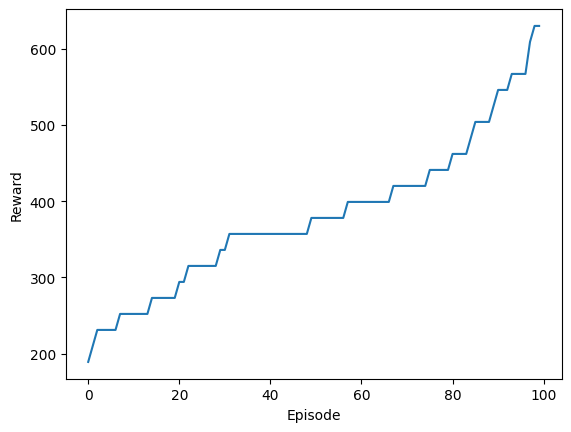

In [9]:
import matplotlib.pyplot as plt

num_envs=1

#env = gym.vector.make(f"{env_name}NoFrameskip-v4", num_envs=num_envs, render_mode='human')
env = gym.vector.make(f"{env_name}NoFrameskip-v4", num_envs=num_envs)
env = MaxLast2FrameSkipWrapper(env,seed=SEED)

def eval_phase(eval_runs=50, max_eval_steps=27000, num_envs=1):
    progress_bar = tqdm.tqdm(total=eval_runs)
    
    scores=[]
    
    state, info = env.reset()
    state = preprocess(state)
    print(f"init state {state.shape}")
    stacked = state.repeat_interleave(3,1)
    state = torch.cat((stacked.clone(), state),1)
    
    
    eps_reward=torch.tensor([0]*num_envs, dtype=torch.float)
    
    reward=np.array([0]*num_envs)
    terminated=np.array([False]*num_envs)

    last_lives=np.array([0]*num_envs)

    finished_envs=np.array([False]*num_envs)
    done_flag=0
    last_grad_update=0
    eval_run=0
    step=np.array([0]*num_envs)
    while eval_run<eval_runs:
        #seed_np_torch(SEED+eval_run)
        env.seed=SEED+eval_run
        model_target.train()
        
        
        Q_action = model_target.env_step(state.unsqueeze(0))
        action = epsilon_greedy(Q_action.squeeze(), 5000, 0.0005, num_envs).cpu()
        
        state, reward, terminated, truncated, info = env.step([action.numpy()] if num_envs==1 else action.numpy())
        done_flag = np.logical_or(terminated, truncated)
        

        state = preprocess(state)
        eps_reward+=reward


        
        state = torch.cat((stacked.clone(), state),1)
        stacked = torch.cat((stacked[:,3:], state[:,-3:]),1)
        
        
        step+=1
        
        log_t = done_flag.astype(float).nonzero()[0]
        if len(log_t)>0:# or (step>max_eval_steps).any():
            progress_bar.update(1)
            for log in log_t:
                #wandb.log({'eval_eps_reward': eps_reward[log].sum()})
                if finished_envs[log]==False:
                    scores.append(eps_reward[log].clone())
                    eval_run+=1
                    #finished_envs[log]=True
                step[log]=0
                
            eps_reward[log_t]=0            
            for i, log in enumerate(step>max_eval_steps):
                if log==True and finished_envs[i]==False:
                    scores.append(eps_reward[i].clone())
                    step[i]=0
                    eval_run+=1
                    eps_reward[i]=0
                    #finished_envs[i]=True
            
    return scores



def eval(eval_runs=50, max_eval_steps=27000, num_envs=1):
    assert num_envs==1, 'The code for num eval envs > 1 is messed up.'
    
    scores = eval_phase(eval_runs, max_eval_steps, num_envs)    
    scores = torch.stack(scores)
    scores, _ = scores.sort()
    
    _25th = eval_runs//4

    iq = scores[_25th:-_25th]
    iqm = iq.mean()
    iqs = iq.std()

    print(f"Scores Mean {scores.mean()}")
    print(f"Inter Quantile Mean {iqm}")
    print(f"Inter Quantile STD {iqs}")

    with open(f'results/MoE-{env_name}-{SEED}.txt', 'w') as f:
        f.write(f" Scores Mean {scores.mean()}\n Inter Quantile Mean {iqm}\n Inter Quantile STD {iqs}")
    
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(scores)
    
    return scores

scores = eval(eval_runs=100, num_envs=1)